# Comparison of wind curl between JRA55-do and ERA5

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
client = Client(n_workers=16)
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-cph0wttv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-54wflpgx', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34281,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:46427,Total threads: 1
Dashboard: /proxy/43727/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:36351,


In [3]:
#! ls /g/data/ik11/inputs/JRA-55/RYF/v1-4
#! ls /g/data/rt52/era5/single-levels/reanalysis/10u/199*/10u*.nc

In [4]:
# Region choice:
x1,x2 = 120.,285.
y1,y2 = -10., 15.

In [5]:
# Calculate and load wind stress JRA55:
JRA55do_u10 = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-4/RYF.uas.1990_1991.nc').sel(lon=slice(x1,x2)).sel(lat=slice(y1,y2))
JRA55do_v10 = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-4/RYF.vas.1990_1991.nc').sel(lon=slice(x1,x2)).sel(lat=slice(y1,y2))

Cd = 0.0015
rhoa = 1.25

JRA55do_taux = (rhoa*Cd*np.sqrt(JRA55do_u10.uas**2.0+JRA55do_v10.vas**2.0)*JRA55do_u10.uas).mean('time').load()
JRA55do_tauy = (rhoa*Cd*np.sqrt(JRA55do_u10.uas**2.0+JRA55do_v10.vas**2.0)*JRA55do_v10.vas).mean('time').load()

In [27]:
# Rough calculation of wind stress curl JRA55:
dlon = JRA55do_v10.lon.diff('lon').mean('lon') # Constant
dlat = JRA55do_v10.lat.diff('lat').mean('lat') # Pretty much constant
Re = 6371000.0
JRA55dody = dlat*np.pi/180.*Re
JRA55dodx = (dlon*np.pi/180.*Re)*np.cos(JRA55do_v10.lat/180.*np.pi)

JRA55do_dtauxdy = JRA55do_taux.diff('lat')/JRA55dody
JRA55do_dtauydx = JRA55do_tauy.diff('lon')/JRA55dodx
JRA55do_curl = JRA55do_dtauydx - JRA55do_dtauxdy # Rough - no averaging

beta = 2*(2*np.pi/86400.)/Re

JRA55_U = (JRA55do_curl.sel(lon=slice(140.,260.)).diff('lat')/JRA55dody).cumsum('lon')*JRA55dodx/beta

In [7]:
# Calculate and load wind stresses ERA-5:
ERA5_u10 = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/10u/199*/10u*.nc').rename({'longitude':'lon','latitude':'lat'}).sel(lat=slice(y2,y1)).sel(time=slice('1990-05-01','1991-04-30'))
ERA5_v10 = xr.open_mfdataset('/g/data/rt52/era5/single-levels/reanalysis/10v/199*/10v*.nc').rename({'longitude':'lon','latitude':'lat'}).sel(lat=slice(y2,y1)).sel(time=slice('1990-05-01','1991-04-30'))

# Roll longitude coordinate:
ERA5_u10 = ERA5_u10.roll(lon=4*180, roll_coords=True);
ERA5_u10 = ERA5_u10.assign_coords(lon=np.where(ERA5_u10.lon.values<=0.,ERA5_u10.lon.values+360.,ERA5_u10.lon.values)) # shift lon
ERA5_v10 = ERA5_v10.roll(lon=4*180, roll_coords=True);
ERA5_v10 = ERA5_v10.assign_coords(lon=np.where(ERA5_v10.lon.values<=0.,ERA5_v10.lon.values+360.,ERA5_v10.lon.values)) # shift lon

ERA5_u10 = ERA5_u10.sel(lon=slice(x1,x2))
ERA5_v10 = ERA5_v10.sel(lon=slice(x1,x2))

Cd = 0.0015
rhoa = 1.25

ERA5_taux = (rhoa*Cd*np.sqrt(ERA5_u10.u10**2.0+ERA5_v10.v10**2.0)*ERA5_u10.u10).mean('time').load()
ERA5_tauy = (rhoa*Cd*np.sqrt(ERA5_u10.u10**2.0+ERA5_v10.v10**2.0)*ERA5_v10.v10).mean('time').load()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.10 GiB -- Worker memory limit: 2.81 GiB


In [28]:
# Rough calculation of wind stress curl ERA5:
dlon = ERA5_v10.lon.diff('lon').mean('lon') # Constant
dlat = ERA5_v10.lat.diff('lat').mean('lat') # Pretty much constant
Re = 6371000.0
ERA5dy = dlat*np.pi/180.*Re
ERA5dx = (dlon*np.pi/180.*Re)*np.cos(ERA5_v10.lat/180.*np.pi)

ERA5_dtauxdy = ERA5_taux.diff('lat')/ERA5dy
ERA5_dtauydx = ERA5_tauy.diff('lon')/ERA5dx
ERA5_curl = ERA5_dtauydx - ERA5_dtauxdy # Rough - no averaging

beta = 2*(2*np.pi/86400.)/Re

ERA5_U = (ERA5_curl.sel(lon=slice(140.,260.)).diff('lat')/ERA5dy).cumsum('lon')*ERA5dx/beta

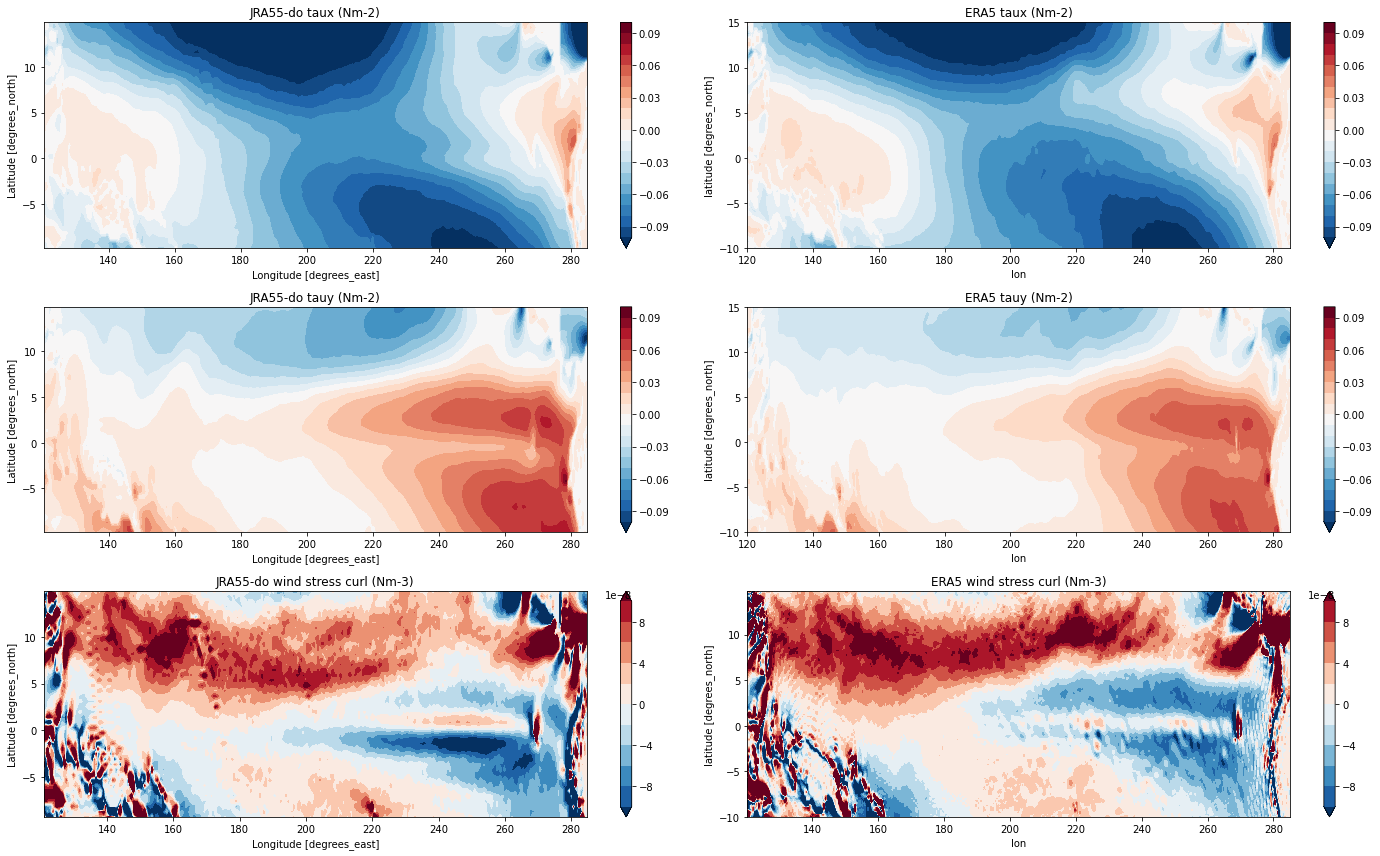

In [31]:
# Plot stresses and curl:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
JRA55do_taux.plot.contourf(levels=np.arange(-1.e-1,1.1e-1,1.e-2),cmap='RdBu_r')
plt.title('JRA55-do taux (Nm-2)')

plt.subplot(3,2,3)
JRA55do_tauy.plot.contourf(levels=np.arange(-1.e-1,1.1e-1,1.e-2),cmap='RdBu_r')
plt.title('JRA55-do tauy (Nm-2)')

plt.subplot(3,2,5)
JRA55do_curl.plot.contourf(levels=np.arange(-1.e-7,1.2e-7,2.e-8),cmap='RdBu_r')
plt.title('JRA55-do wind stress curl (Nm-3)')

#plt.subplot(4,2,7)
#JRA55_U.plot()#.contourf(levels=np.arange(-1.e2,1.2e2,2.e1),cmap='RdBu_r')
#plt.title('JRA55-do Zonal Transport (m2s-1)')

plt.subplot(3,2,2)
ERA5_taux.plot.contourf(levels=np.arange(-1.e-1,1.1e-1,1.e-2),cmap='RdBu_r')
plt.title('ERA5 taux (Nm-2)')

plt.subplot(3,2,4)
ERA5_tauy.plot.contourf(levels=np.arange(-1.e-1,1.1e-1,1.e-2),cmap='RdBu_r')
plt.title('ERA5 tauy (Nm-2)')

plt.subplot(3,2,6)
ERA5_curl.plot.contourf(levels=np.arange(-1.e-7,1.2e-7,2.e-8),cmap='RdBu_r')
plt.title('ERA5 wind stress curl (Nm-3)')

#plt.subplot(4,2,8)
#ERA5_U.plot()#.contourf(levels=np.arange(-1.e2,1.2e2,2.e1),cmap='RdBu_r')
#plt.title('ERA5 Zonal Transport (m2s-1)')

plt.tight_layout()
plt.savefig('JRA55_ERA5_WindStress_Comparison_19901991.png')

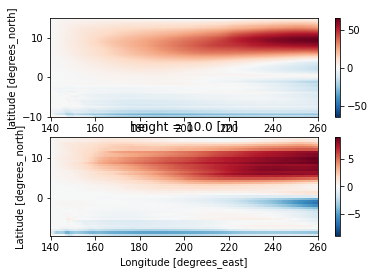

In [19]:
# Try calculating a Sverdrup-ish zonal transport:
JRA55_U = JRA55do_curl.sel(lon=slice(140.,260.)).cumsum('lon')/JRA55dodx/beta
ERA5_U = ERA5_curl.sel(lon=slice(140.,260.)).cumsum('lon')/ERA5dx/beta

plt.subplot(2,1,1)
ERA5_U.plot()
plt.subplot(2,1,2)
JRA55_U.plot()

In [ ]:
#metss	Mean eastward turbulent surface stress [N m**-2]	('time', 'latitude', 'longitude')	[93, 91, 180]	/g/data/rt52/era5/single-levels/reanalysis/metss/*/metss*.nc
#mntss	Mean northward turbulent surface stress [N m**-2]	('time', 'latitude', 'longitude')	[93, 91, 180]	/g/data/rt52/era5/single-levels/reanalysis/mntss/*/mntss*.nc
#u10	10 metre U wind component [m s**-1]	('time', 'latitude', 'longitude')	[93, 91, 180]	/g/data/rt52/era5/single-levels/reanalysis/10u/*/10u*.nc
#u10n	Neutral wind at 10 m u-component [m s**-1]	('time', 'latitude', 'longitude')	[93, 91, 180]	/g/data/rt52/era5/single-levels/reanalysis/u10n/*/u10n*.nc